In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from ase.build import bulk

Mg_conv_cell = bulk("MgO", crystalstructure="rocksalt", a=4.2, cubic=True)
rng = np.random.default_rng(42)
replace_element = "Mg"
new_elements=("Mg", "Fe")
ratio = 0.5

In [ ]:
from monty.serialization import loadfn
import tc.dataset
import tc.testing
from mace.calculators import mace_mp

# Only create the ensembles if they do not already exist
try:
    ensemble = loadfn(f"{''.join(new_elements)}O_ensemble4.json.gz")
    print("Ensemble already exist, skipping creation.")
except FileNotFoundError:
    print("Creating new ensembles...")
    calc = mace_mp(model="large", device="cuda", default_dtype="float64")
    ensembles = tc.dataset.make_ce_ensembles_from_mace(conv_cell=Mg_conv_cell, rng=rng, calc=calc, ratio=ratio, 
                                                       replace_element=replace_element, new_elements=new_elements, bin_counts=200)
    for ensemble in ensembles:
        stats = tc.testing.evaluate_ensemble_vs_mace(ensemble=ensemble, calc=calc, conv_cell=Mg_conv_cell, rng=rng, 
                                                     replace_element=replace_element, new_elements=new_elements)

    ensemble_4, ensemble_6, ensemble_8, ensemble_10, ensemble_12 = ensembles
    ensemble = ensemble_4



/home/colin/miniforge/envs/tc312/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))


Creating new ensembles...
Using Materials Project MACE for MACECalculator with /home/colin/.cache/mace/MACE_MPtrj_20229model
Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.


/home/colin/miniforge/envs/tc312/lib/python3.12/site-packages/mace/calculators/mace.py:143: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


Using head Default out of ['Default']
Total snapshots: 200 for 864 cations


MACE energies:   0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

CE energies: mean = -9778.11 meV, std =   477.10 meV, min = -11655.29 meV, max = -7335.10 meV
Energy window : [-21.706, 6.920] eV (200 bins, 0.1431 eV each)


Sampling 1 chain(s) from a cell with 512 sites: 100%|██████████| 102400000/102400000 [2:20:42<00:00, 12129.50it/s] 


Debug: ensemble.processor.size = 64
Debug: ensemble.num_sites = 512
Debug: ratio = 8.0
min(raw) = -19.987984541009325 eV
max(raw) = 5.632122830045233 eV
ΔE = 25.62010737105456 eV


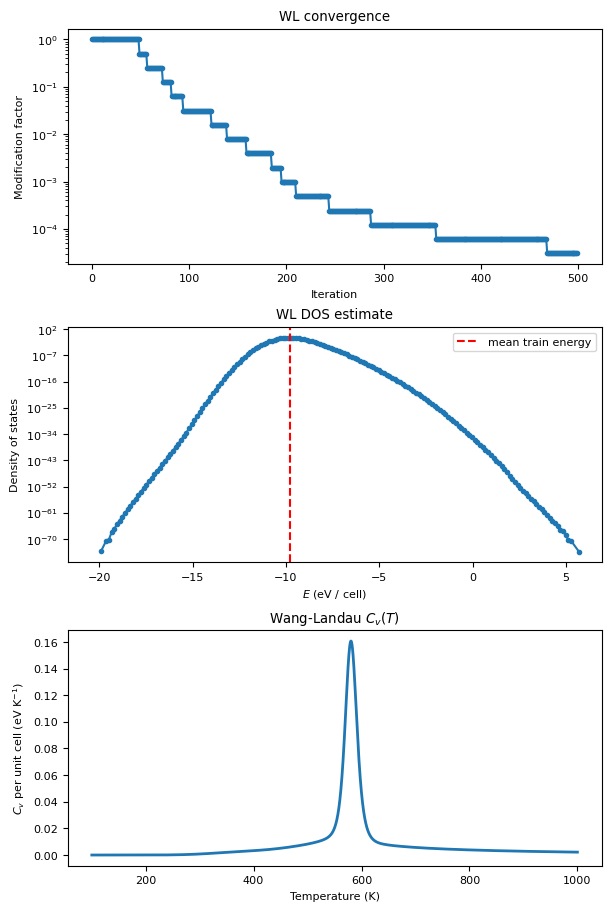

In [ ]:
import tc.wang_landau
samples = tc.testing.sample_configs_fast(ensemble, rng, n_samples=10_000, ratio=ratio)
sampler, mu, min_E, max_E, bin_size = tc.wang_landau.run_wang_landau(ensemble=ensemble, samples=samples, rng=rng, ratio=ratio, n_samples_per_site=500_000, num_bins=200, window_width_factor=(25,35))
temperatures_K = np.linspace(100.0, 1000.0, 10_000)
Cv = tc.wang_landau.compute_thermodynamics(sampler, ensemble, temperatures_K)
tc.wang_landau.generate_wl_plots( mu, min_E, max_E, bin_size, sampler, temperatures_K, Cv)

Metropolis:   0%|          | 0/200 [00:00<?, ?T/s]

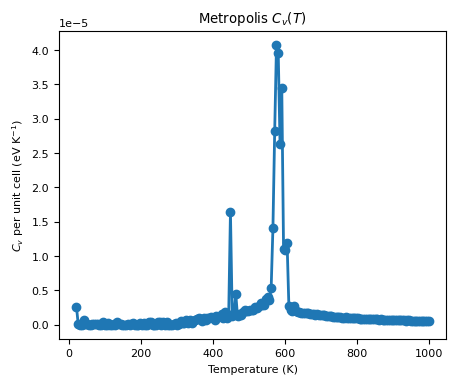

In [ ]:
"""
Parallel Metropolis heat-capacity sweep
--------------------------------------
Drop-in replacement for your original for-loop.
"""

import os, numpy as np
from concurrent.futures import ProcessPoolExecutor
from tqdm.auto import tqdm
import tc.metropolis

# ------------------------------------------------------------------ #
# 1.  Temperatures you want to sample and an independent RNG seed for
#     every worker (avoids accidental correlations).
# ------------------------------------------------------------------ #
Ts        = np.linspace(100, 1000, 200)
seed_root = np.random.SeedSequence(42)       # master seed
child_seeds = seed_root.spawn(len(Ts))       # one per T

# ------------------------------------------------------------------ #
# 2.  Worker helper → *must* be at top level so it can be pickled.
#     We keep n_steps_per_site modest (250) now that we’re
#     parallelising and reusing equilibrated states.
# ------------------------------------------------------------------ #
def _single_Cv(T, seed):
    rng = np.random.default_rng(seed)
    return tc.metropolis.run_metropolis_heat_capacity(
        ensemble,          # cheap shallow copy is enough
        T,
        rng,
        replace_element="Mg",
        new_elements=("Mg", "Fe"),
        ratio=0.5,
        n_steps_per_site=10_000,
        thin_target=40_000,
    )

# ------------------------------------------------------------------ #
# 3.  Fan the temperature points out to all available cores.
#     Using executor.map keeps results in the same order as Ts.
# ------------------------------------------------------------------ #
n_workers = os.cpu_count() // 2                     # use every logical core
with ProcessPoolExecutor(max_workers=n_workers) as pool:
    Cv = list(
        tqdm(
            pool.map(_single_Cv, Ts, child_seeds),
            total=len(Ts),
            desc="Metropolis",
            unit="T",
        )
    )

# ------------------------------------------------------------------ #
# 4.  Plot as before
# ------------------------------------------------------------------ #
tc.metropolis.plot_cv_curve(Ts, Cv)
